In [239]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma, expon, binom, norm
from scipy.stats import gaussian_kde

from utils import update_prior, mix_dist, normalize_dist, prob_superiority

sns.set_style("whitegrid")


def fit_gaussian_kde_pmf(sample, qs):
    kde = gaussian_kde(sample)
    pmf = kde(qs)
    pmf = pd.Series(normalize_dist(pmf), index=qs)
    return pmf


def dist_mean(dist):
    mu = (dist.index.values * dist.values).sum()
    return mu


def dist_moment(dist, moment=2):
    mu = dist_mean(dist)
    m = np.sum((dist.index.values - mu) ** moment * dist.values) ** (1/moment)
    return m

In [240]:
def read_showcase_data():
    paths = [
        r'https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/showcases.2011.csv',
        r'https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/showcases.2012.csv',
    ]

    data = []
    for path in paths:
        _df = pd.read_csv(path, index_col=0, skiprows=[1]).dropna().T
        data.append(_df)
    
    df = pd.concat(data, ignore_index=True)
    return df

Mean = 30299.49 31047.68


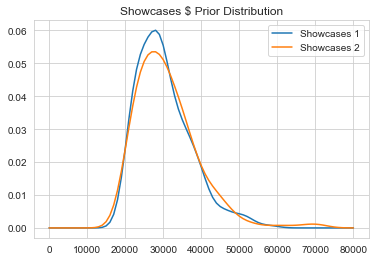

In [89]:
showcase_df = read_showcase_data()

showcase_qs = np.linspace(0, 80000, 81)
showcase_pmf1 = fit_gaussian_kde_pmf(showcase_df['Showcase 1'], showcase_qs)
showcase_pmf2 = fit_gaussian_kde_pmf(showcase_df['Showcase 2'], showcase_qs)

print('Mean = %.2f %.2f' % (showcase_df['Showcase 1'].mean(), showcase_df['Showcase 2'].mean()))
showcase_pmf1.plot(label='Showcases 1')
showcase_pmf2.plot(label='Showcases 2')
plt.legend()
_ = plt.title('Showcases $ Prior Distribution')

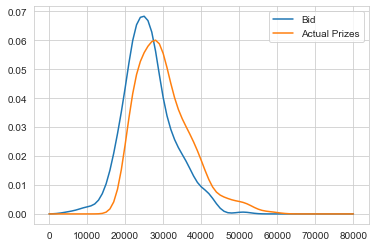

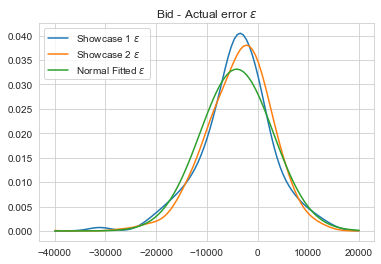

In [238]:
# Bidding [Error = Guess - Actual] analysis
# They tends to underbid from the guess as being strategic, but assumes E[Guess] - E[Actual] = 0

fit_gaussian_kde_pmf(showcase_df['Bid 1'], showcase_qs).plot(label='Bid')
fit_gaussian_kde_pmf(showcase_df['Showcase 1'], showcase_qs).plot(label='Actual Prizes')
plt.legend()
plt.show()


e_qs = np.linspace(-40000, 20000, 101)
diff1 = fit_gaussian_kde_pmf(showcase_df['Bid 1'] - showcase_df['Showcase 1'], e_qs)
diff2 = fit_gaussian_kde_pmf(showcase_df['Bid 2'] - showcase_df['Showcase 2'], e_qs)

diff1.plot(label='Showcase 1 $\epsilon$')
diff2.plot(label='Showcase 2 $\epsilon$')
plt.plot(e_qs, normalize_dist(norm.pdf(e_qs, loc=dist_mean(diff1), scale=dist_moment(diff1, 2))), label='Normal Fitted $\epsilon$')
_ = plt.legend()
_ = plt.title('Bid - Actual error $\epsilon$')
plt.show()

Prior Mean = 30,299.49 	Posterior Mean = 26,338.98


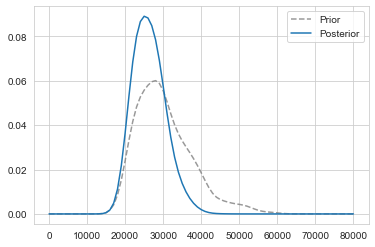

In [316]:
# Showcase 1 $ Posterior
data = 23000  # guess is this, we shall update our prior belief of prizes over all possible error
prior = showcase_pmf1
likelihood = norm.pdf(data-showcase_qs, loc=0, scale=dist_moment(diff1, 2))
posterior1 = update_prior(prior, likelihood)

print(
    'Prior Mean = {:,.2F}'.format((prior.index.values * prior.values).sum()),
    '\tPosterior Mean = {:,.2f}'.format((posterior1.index.values * posterior1.values).sum()),
)
prior.plot(color='gray', linestyle='--', alpha=0.8, label='Prior')
posterior1.plot(label='Posterior')
plt.legend()
plt.show()

Prior Mean = 31,047.62 	Posterior Mean = 34,430.22


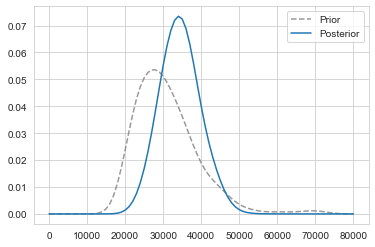

In [317]:
# Showcase 2 $ Posterior
data = 38000  # guess is this, we shall update our prior belief of prizes over all possible error
prior = showcase_pmf2
likelihood = norm.pdf(data-showcase_qs, loc=0, scale=dist_moment(diff2, 2))
posterior2 = update_prior(prior, likelihood)

print(
    'Prior Mean = {:,.2F}'.format((prior.index.values * prior.values).sum()),
    '\tPosterior Mean = {:,.2f}'.format((posterior2.index.values * posterior2.values).sum()),
)
prior.plot(color='gray', linestyle='--', alpha=0.8, label='Prior')
posterior2.plot(label='Posterior')
plt.legend()
plt.show()

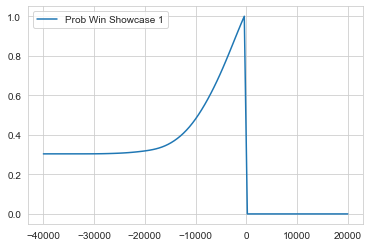

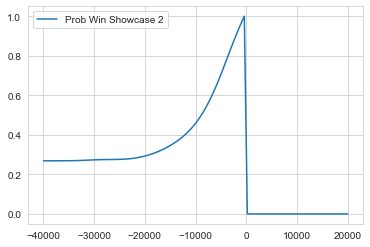

In [318]:
# Error -> Winning Rate

def prob_win(error, opp_dist):
    if error > 0:
        return 0
    
    p1 = opp_dist[opp_dist.index<=error].sum()
    p2 = opp_dist[opp_dist.index>0].sum()
    return p1 + p2


pwin1 = [prob_win(e, diff2) for e in e_qs]
pwin2 = [prob_win(e, diff1) for e in e_qs]

plt.plot(e_qs, pwin1, label='Prob Win Showcase 1')
_ = plt.legend()
plt.show()

plt.plot(e_qs, pwin2, label='Prob Win Showcase 2')
_ = plt.legend()
plt.show()

Guess = 23000, Optimal Bid = 21000


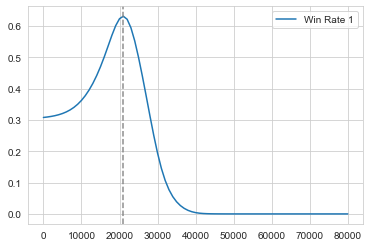

Guess = 38000, Optimal Bid = 29000


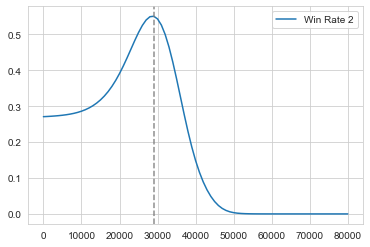

In [322]:
# from error to estimate winning distribution
# now use the error winning distribution + posterior actual price distrubtion + data to estimate winning rate distribution

def total_prob_win(bid, posterior, opp_dist):
    total = 0
    for q, p in posterior.items():
        e = bid - q
        _p = p * prob_win(e, opp_dist)
        total += _p
    return total
    

ppwin1 = pd.Series([total_prob_win(b, posterior1, diff2) for b in posterior1.index.values], index=posterior.index)
ppwin2 = pd.Series([total_prob_win(b, posterior2, diff1) for b in posterior2.index.values], index=posterior2.index)

print('Guess = 23000, Optimal Bid = {:.0f}'.format(ppwin1.idxmax()))
plt.plot(posterior1.index.values, ppwin1, label='Win Rate 1')
plt.axvline(ppwin1.idxmax(), color='gray', linestyle='--', alpha=0.9)
_ = plt.legend()
plt.show()

print('Guess = 38000, Optimal Bid = {:.0f}'.format(ppwin2.idxmax()))
plt.plot(posterior2.index.values, ppwin2, label='Win Rate 2')
plt.axvline(ppwin2.idxmax(), color='gray', linestyle='--', alpha=0.9)
_ = plt.legend()
plt.show()

Guess = 23000, Optimal Bid = 22000


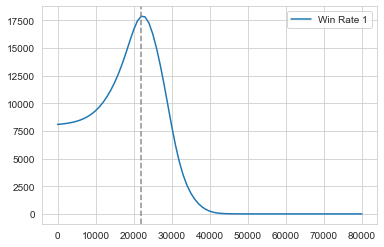

Guess = 38000, Optimal Bid = 30000


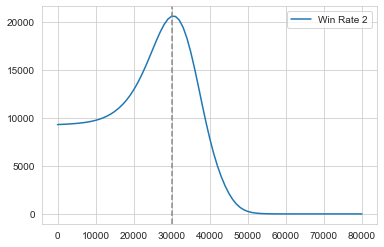

In [321]:
# instead of max winning probability
# looking at max expected gain: error within -250 ~ 0 wins the double of the prizes

def expected_gain(bid, price, opp_dist):
    e = bid - price
    p = prob_win(e, opp_dist)

    gain = price * p
    if -250 <= e <= 0:
        gain *= 2
    
    return gain


def total_expected_gain(bid, posterior, opp_dist):
    total = 0
    for q, p in posterior.items():
        _g = p * expected_gain(bid, q, opp_dist)
        total += _g
    return total


ppwin1 = pd.Series([total_expected_gain(b, posterior1, diff2) for b in posterior1.index.values], index=posterior.index)
ppwin2 = pd.Series([total_expected_gain(b, posterior2, diff1) for b in posterior2.index.values], index=posterior2.index)

print('Guess = 23000, Optimal Bid = {:.0f}'.format(ppwin1.idxmax()))
plt.plot(posterior1.index.values, ppwin1, label='Win Rate 1')
plt.axvline(ppwin1.idxmax(), color='gray', linestyle='--', alpha=0.9)
_ = plt.legend()
plt.show()

print('Guess = 38000, Optimal Bid = {:.0f}'.format(ppwin2.idxmax()))
plt.plot(posterior2.index.values, ppwin2, label='Win Rate 2')
plt.axvline(ppwin2.idxmax(), color='gray', linestyle='--', alpha=0.9)
_ = plt.legend()
plt.show()